开局先加载下一些必要的框架

In [1]:
import torch
from safetensors.torch import load_model

下面这3个就是咱们的代码实现了

In [2]:
import configuration_chatglm_full as configuration_chatglm
from glm import ChatGLMForConditionalGeneration
from tokenization_chatglm import ChatGLMTokenizer

接下来获取模型的配置

这个配置包含了模型架构的一些信息，比如输入输出的维度，隐藏层大小等，如果这些参数对不上，那就加载不了他们训练好的模型了

In [3]:
config = configuration_chatglm.ChatGLMConfig()

In [4]:
# 如果电脑配置实在太拉跨，可以解除下面代码的注释，减小下GLM模型的参数，但同时也加载不了现有参数了
# config.ffn_hidden_size = 512
# config.num_layers = 3
# config.hidden_size = 256

In [5]:
# 对于像笔者这样显存不够大的电脑，就需要对模型进行量化了，这里对模型做int4量化，但如果你的显存小于6G，那就只能用CPU跑，或者减少模型参数了。
m = ChatGLMForConditionalGeneration(config=config, device='cpu')
# 如果前面改了模型架构，就不要执行下面的代码加载权重了，因为模型架构改了，权重就不对了。
# 设置 strict=False 是必须的，因为权重文件包含了一部分的权重，load_model方法默认会加载全部权重，不设置这参数就会直接报错。
load_model(m, "weights/model-00001-of-00007.safetensors", strict=False)
load_model(m, "weights/model-00002-of-00007.safetensors", strict=False)
load_model(m, "weights/model-00003-of-00007.safetensors", strict=False)
load_model(m, "weights/model-00004-of-00007.safetensors", strict=False)
load_model(m, "weights/model-00005-of-00007.safetensors", strict=False)
load_model(m, "weights/model-00006-of-00007.safetensors", strict=False)
load_model(m, "weights/model-00007-of-00007.safetensors", strict=False)

m = m.quantize(bits=4, device='cuda')
m = m.to('cuda')
m = m.eval()

## 模型的输入和输出
研究一个神经网络模型，最需要要了解的，就是模型的输入和输出。

而当下的语言模型，输入是一个token序列，输出是各个token的logits概率。

现在构造一个5个token的输入丢进去试试。

In [6]:
x = torch.tensor([[5262, 26267, 26236, 632, 6241]], device='cuda', dtype=torch.long)

In [7]:
x.shape

torch.Size([1, 5])

In [8]:
with torch.no_grad():
    out = m(x)

D:\sys2\llms-from-scratch-cn\Model_Architecture_Discussions\ChatGLM3\glm.py:251: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(query_layer, key_layer, value_layer,


In [9]:
out.logits

tensor([[[-3.5352, -3.5352,  0.7764,  ..., -3.5352, -3.5352, -3.5352],
         [-2.1719, -2.1719,  4.2031,  ..., -2.1719, -2.1738, -2.1719],
         [-0.4954, -0.4951,  5.5820,  ..., -0.4946, -0.4951, -0.4951],
         [-2.7090, -2.7090,  4.4453,  ..., -2.7090, -2.7090, -2.7090],
         [-1.7568, -1.7568,  5.7383,  ..., -1.7578, -1.7568, -1.7578]]],
       device='cuda:0', dtype=torch.float16)

In [10]:
out.logits.shape

torch.Size([1, 5, 65024])

前面我给它构造了5个token，输入的shape是[1, 5]，而输出的shape是[1, 5, 65024]

最后一维的65024很好理解，就是vocab_size，代表词表中每个词被输出概率

而第二维的5就有些费解了，按理说咱们做的是next token prediction的任务，可为什么一下预测了5个token呢？其实只有最后一个token的预测结果是有用的，前面那4个都是直接丢弃的，下面画个图简单演示下流程。

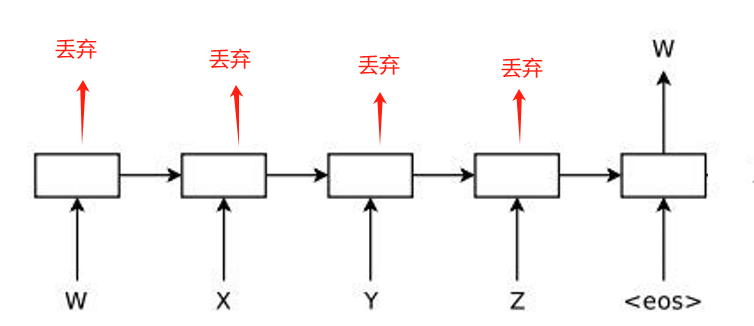

接下来再看看这输出的token具体是哪个。

In [11]:
next_token = torch.argmax(out.logits[:, -1, :], dim=-1)
next_token

tensor([30968], device='cuda:0')

所以这30968号token到底是哪个字呢？咱们加载下tokenizer解码下。

In [12]:
tokenlizer = ChatGLMTokenizer(vocab_file='tokenizer.model')

In [13]:
tokenlizer.batch_decode(next_token)

['z']

现在，咱们已经能简单的预测出下一个token了，下面咱们就这样自回归的预测下去试试吧。

当然，这次用tokenlizer把文本转化为有意义的token序列

In [14]:
inputs = tokenlizer(['为什么A股指数跌的不多，但是我亏损比之前都多？'], add_special_tokens=False)
inputs

{'input_ids': [[30910, 32148, 30938, 55128, 33488, 56156, 33069, 54573, 31123, 45990, 37768, 54703, 32030, 54606, 54573, 31514]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'position_ids': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]}

可以看到tokenization后有3个参数，分别是input_ids，attention_mask，和position_ids。

后2个可以不管，因为这些参数在模型推理时可以自动生成。

现在咱们一直预测下一个token，直到模型输出的token是eos（代表模型输出结束的token）为止。

In [15]:
input_ids = inputs['input_ids']
input_ids = torch.tensor(input_ids, device='cuda')

print(tokenlizer.decode(input_ids[0]))

with torch.no_grad():
    for i in range(500):
        output = m(input_ids)

        result = torch.argmax(output.logits[:, -1, :], dim=-1)

        if result.item() == tokenlizer.eos_token_id:
            break

        print(tokenlizer.decode(result[0], skip_special_tokens=True), end='')
        
        input_ids = torch.cat([input_ids, result.reshape(-1, 1)],
                              dim=1)
    
    print('\n\n======================\n\n', tokenlizer.decode(input_ids[0], skip_special_tokens=True), end='\n')

为什么A股指数跌的不多，但是我亏损比之前都多？
<0x0A>为什么A股指数跌的不多，但是我亏损比之前都多？<0x0A>这个问题涉及到多个方面的因素,以下是一些可能的原因:<0x0A><0x0A>1.投资策略不同:A股指数是市场整体的表现,而个人投资者可能会选择不同的投资策略,例如买入某些行业或股票,而另一种策略是卖出某些行业或股票。如果您的投资策略与市场整体表现不同,那么您的投资组合可能会遭受负面影响,即使A股指数并未下跌很多。<0x0A><0x0A>2.风险控制不同:A股市场有风险,但是不同投资者可能会采取不同的风险控制措施。例如,一些投资者可能会选择使用止损单来减少损失,而其他人可能会选择持有股票直到市场复苏。如果您的风险控制策略与市场整体表现不同,那么您的投资组合可能会遭受负面影响。<0x0A><0x0A>3.市场情绪不同:即使A股指数并未下跌很多,但是市场情绪可能会导致投资者感到不安,从而导致股市下跌。例如,如果市场预期经济衰退,那么投资者可能会减少投资,导致股市下跌。另一方面,如果市场情绪乐观,投资者可能会增加投资,导致股市上涨。<0x0A><0x0A>4.行业表现不同:即使A股指数未下跌很多,某些行业或股票可能表现不佳,导致投资者亏损。例如,某些行业可能会受到宏观经济因素的影响,导致其表现不佳,而其他行业则可能受益于相同的因素而表现良好。<0x0A><0x0A>5.交易成本不同:在A股市场中,投资者需要支付交易成本,包括股票交易费和基金管理费等。如果交易成本较高,那么投资者的亏损可能会更大,即使A股指数未下跌很多。<0x0A><0x0A>总结起来,以上这些因素都可能会导致投资者在A股市场中的表现与市场整体表现不同。因此,对于个人投资者而言,了解市场和自己的投资策略,制定合理的投资计划和风险控制措施,是减少亏损的关键。


 为什么A股指数跌的不多，但是我亏损比之前都多？
为什么A股指数跌的不多，但是我亏损比之前都多？
 这个问题涉及到多个方面的因素,以下是一些可能的原因:

1. 投资策略不同:A股指数是市场整体的表现,而个人投资者可能会选择不同的投资策略,例如买入某些行业或股票,而另一种策略是卖出某些行业或股票。如果您的投资策略与市场整体表现不同,那么您的投资组合可能会遭受负面影响,即使A股指数并未下跌很多。

2. 风险控制不同:A股市场有风险,但是

总之就很显然，一个合格的LLM就被咱们搭出来了，但目前的实现还是有些问题的，比如：

1. 每次输出都是固定的
2. 缺少Chat Format（多轮对话的标记语言）

这2个问题咱们留到后面解决